In [1]:
import numpy as np
import pandas as pd
from openpyxl import Workbook

class Random:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        
    def normal(self, mean, stddev):
        return self.rng.normal(mean, stddev)

def generate_demand(periods=15):
    D = []
    b = 90
    c = 0.3 * b
    e = Random()  # No seed for practice mode
    while True:
        a = e.normal(b, c)
        if a > 0:
            break
    b = a
    D.append(a)
    c = min(30, 0.3 * b)
    for _ in range(1, periods):
        while True:
            a = e.normal(b, c)
            if a > 0:
                break
        D.append(a)
    return D

def calc_demand(D, week, multiplier):
    return D[week] * multiplier

def simulate_player_strategy(threshold=300, periods=15):
    D = generate_demand(periods)
    mult = [1, 1.3, 1.75, 2.8]
    prices = [60, 54, 48, 36]
    current_price_index = 0
    I = 2000
    revenue = 0
    sales = []
    price_clicks = [0, 0, 0, 0]

    for week in range(periods):
        # Maintain the price at $60 for the first 3 weeks
        if week >= 3:
            recent_sales_sum = sum(sales[-3:])
            if recent_sales_sum < threshold:
                # Move to the next price level if the current one has been clicked
                if price_clicks[current_price_index] > 0:
                    current_price_index = min(current_price_index + 1, len(prices) - 1)

        current_price = prices[current_price_index]
        current_multiplier = mult[current_price_index]
        weekly_demand = calc_demand(D, week, current_multiplier)
        actual_sales = min(weekly_demand, I)
        revenue += current_price * actual_sales
        I -= actual_sales
        sales.append(actual_sales)

        # Mark the price button as clicked
        price_clicks[current_price_index] += 1

        # Uncomment to print out the weekly details for debugging
        # print(f"Week {week + 1}: Price = ${current_price}, Sales = {actual_sales}, Inventory = {I}, Revenue = {revenue}")

        if I <= 0:
            break

    return revenue, D

# When the sale of the week < threshold, still maintain that price for the next week, but if the sale of next week is still < threshold, move to the next price level
def simulate_player_strategy2(threshold=133, periods=15):
    D = generate_demand(periods)
    mult = [1, 1.3, 1.75, 2.8]
    prices = [60, 54, 48, 36]
    current_price_index = 0
    I = 2000
    revenue = 0
    sales = []
    below_threshold_weeks = 0

    for week in range(periods):
        # Determine the price and multiplier for the current week
        current_price = prices[current_price_index]
        current_multiplier = mult[current_price_index]
        
        # Calculate weekly demand and actual sales
        weekly_demand = calc_demand(D, week, current_multiplier)
        actual_sales = min(weekly_demand, I)
        
        # Update revenue and inventory
        revenue += current_price * actual_sales
        I -= actual_sales
        sales.append(actual_sales)
        
        # Check if sales are below the threshold for consecutive weeks
        if actual_sales < threshold:
            below_threshold_weeks += 1
        else:
            below_threshold_weeks = 0

        # Adjust price level if sales are below threshold for two consecutive weeks
        if below_threshold_weeks == 2:
            current_price_index = min(current_price_index + 1, len(prices) - 1)
            below_threshold_weeks = 0  # Reset the counter after moving to the next price level

        # Break if inventory is depleted
        if I <= 0:
            break

    return revenue, D

# Maintain the initial price for the initial periods, move to the next price level if cumulative sales < threshold * number of weeks passed
def simulate_player_strategy3(threshold=133, initial_period = 2, periods=15):
    D = generate_demand(periods)
    mult = [1, 1.3, 1.75, 2.8]
    prices = [60, 54, 48, 36]
    current_price_index = 0
    I = 2000
    revenue = 0
    sales = []

    for week in range(periods):
        current_price = prices[current_price_index]
        current_multiplier = mult[current_price_index]
        weekly_demand = calc_demand(D, week, current_multiplier)
        actual_sales = min(weekly_demand, I)
        revenue += current_price * actual_sales
        I -= actual_sales
        sales.append(actual_sales)

        if week >= initial_period and sum(sales) < ((week+1) * threshold):
            current_price_index = min(current_price_index + 1, len(prices) - 1)

        if I <= 0:
            break

    return revenue, D

def calcRev(D, a, b, c, periods, mult, salvage=0):
    e = 0
    d = 2000
    for f in range(a):
        g = min(D[f] * mult[0], d)
        d -= g
        e += 60 * g
    for f in range(a, a + b):
        g = min(D[f] * mult[1], d)
        d -= g
        e += 54 * g
    for f in range(a + b, a + b + c):
        g = min(D[f] * mult[2], d)
        d -= g
        e += 48 * g
    for f in range(a + b + c, periods):
        g = min(D[f] * mult[3], d)
        d -= g
        e += 36 * g
    return e + d * salvage

def perfect_foresight(D, periods, mult):
    e = 0
    for a in range(1, periods + 1):
        for b in range(0, periods - a + 1):
            for c in range(0, periods - a - b + 1):
                d = calcRev(D, a, b, c, periods, mult)
                if d > e:
                    e = d
    return e

def play_game_n_times(n, threshold, strategy, initial_period=None):
    results = []
    mult = [1, 1.3, 1.75, 2.8]

    for i in range(n):
        if strategy == 1:
            player_revenue, D = simulate_player_strategy(threshold)
        elif strategy == 2:
            player_revenue, D = simulate_player_strategy2(threshold)
        else:
            player_revenue, D = simulate_player_strategy3(threshold, initial_period)

        perfect_revenue = perfect_foresight(D, 15, mult)
        difference = perfect_revenue - player_revenue
        difference_percentage = difference / perfect_revenue * 100

        results.append({
            'Attempt': i + 1,
            'Player Revenue': player_revenue,
            'Perfect Revenue': perfect_revenue,
            'Difference': difference,
            'Difference Percentage': difference_percentage
        })

    return results

def save_results_to_excel(results, filename='game_results.xlsx'):
    df = pd.DataFrame(results)
    df.to_excel(filename, index=False)

In [5]:
# Find optimal threshold for strategy 1
thresholds = [*range(270, 399, 5)]
threshold_results = []
optimal_threshold = None
optimal_median_difference_percentage = 100
n=1000

for threshold in thresholds:
    results = play_game_n_times(n, threshold, strategy=1)
    # Median of difference percentage as the metric to find optimal threshold
    median_difference_percentage = pd.DataFrame(results)['Difference Percentage'].median()
    threshold_results.append({
        'Threshold': threshold,
        'Median Difference Percentage': median_difference_percentage
    })
    
    if median_difference_percentage < optimal_median_difference_percentage:
        optimal_median_difference_percentage = median_difference_percentage
        optimal_threshold = threshold

# Print the optimal
print(f"The optimal threshold is: {optimal_threshold}")
print(f"The optimal median differnce percentage is: {optimal_median_difference_percentage}")

The optimal threshold is: 300
The optimal median differnce percentage is: 4.957979175384928


In [2]:
# For strategy 1, run the simulation n times for optimal threshold and save the results
n = 10000  # Number of attempts
results = play_game_n_times(n, threshold=300, strategy=1)
save_results_to_excel(results, filename='game_results.xlsx')

print(f"Results saved to 'game_results.xlsx'")

Results saved to 'game_results.xlsx'


In [3]:
# Summary statistics of the result
pd.DataFrame(results)[['Player Revenue', 'Difference Percentage']].describe()

,Player Revenue,Difference Percentage
count,10000.000000,10000.000000
mean,92988.016463,5.939094
std,18082.602992,4.933190
min,2799.384724,0.000000
25%,80211.672347,2.240182
50%,98069.625473,4.904249
75%,105568.984309,8.397640
max,120000.000000,28.310755


<Axes: ylabel='Difference Percentage'>

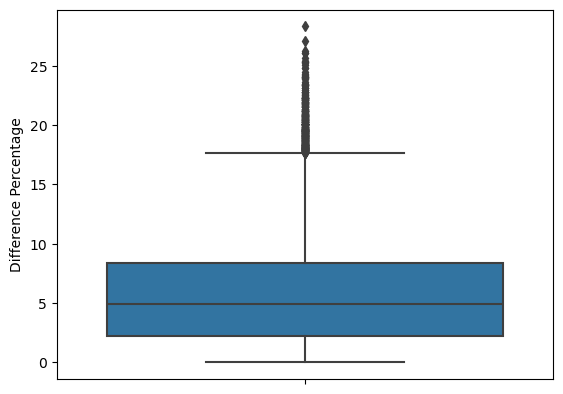

In [4]:
import seaborn as sns
sns.boxplot(y='Difference Percentage', data=pd.DataFrame(results))

In [5]:
# Find optimal threshold for strategy 2
thresholds = [*range(100, 151, 5)]
threshold_results = []
optimal_threshold = None
optimal_median_difference_percentage = 100
n=1000

for threshold in thresholds:
    results = play_game_n_times(n, threshold, strategy=2)
    # Median of difference percentage as the metric to find optimal threshold
    median_difference_percentage = pd.DataFrame(results)['Difference Percentage'].median()
    threshold_results.append({
        'Threshold': threshold,
        'Median Difference Percentage': median_difference_percentage
    })
    
    if median_difference_percentage < optimal_median_difference_percentage:
        optimal_median_difference_percentage = median_difference_percentage
        optimal_threshold = threshold

# Print the optimal
print(f"The optimal threshold is: {optimal_threshold}")
print(f"The optimal median differnce percentage is: {optimal_median_difference_percentage}")

The optimal threshold is: 115
The optimal median differnce percentage is: 3.8487197858266704


In [14]:
# For strategy 2, run the simulation n times for optimal threshold and save the results
n = 10000  # Number of attempts
results = play_game_n_times(n, threshold=115, strategy=2)
save_results_to_excel(results, filename='game_results2.xlsx')

print(f"Results saved to 'game_results2.xlsx'")

Results saved to 'game_results2.xlsx'


In [15]:
# Summary statistics of the result
pd.DataFrame(results)[['Player Revenue', 'Difference Percentage']].describe()

,Player Revenue,Difference Percentage
count,10000.000000,10000.000000
mean,94078.114032,4.602506
std,17869.518633,3.406648
min,759.875896,0.000000
25%,83637.821128,1.849119
50%,98726.527177,4.002031
75%,107655.118284,6.936883
max,120000.000000,22.087428


<Axes: ylabel='Difference Percentage'>

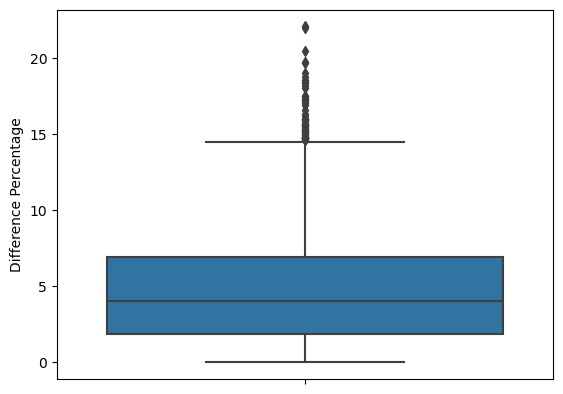

In [16]:
sns.boxplot(y='Difference Percentage', data=pd.DataFrame(results))

In [17]:
# Find optimal threshold and initial period for strategy 3
thresholds = [*range(100, 151, 5)]
par_results = []
optimal_threshold = None
optimal_median_difference_percentage = 100
n = 1000
initial_periods = [1, 2, 3, 4]
optimal_initial = None

for initial_period in initial_periods:
    for threshold in thresholds:
        results = play_game_n_times(n, threshold, strategy=3, initial_period=initial_period)
        # Median of difference percentage as the metric to find optimal threshold
        median_difference_percentage = pd.DataFrame(results)['Difference Percentage'].median()
        par_results.append({
            'Threshold': threshold,
            'Initial Period': initial_period,
            'Median Difference Percentage': median_difference_percentage
        })
        
        if median_difference_percentage < optimal_median_difference_percentage:
            optimal_median_difference_percentage = median_difference_percentage
            optimal_threshold = threshold
            optimal_initial = initial_period

# Print the optimal
print(f"The optimal threshold is: {optimal_threshold}")
print(f"The optimal initial period is: {optimal_initial}")
print(f"The optimal median differnce percentage is: {optimal_median_difference_percentage}")

The optimal threshold is: 105
The optimal initial period is: 1
The optimal median differnce percentage is: 5.869154147619845


In [18]:
# For strategy 3, run the simulation n times for optimal threshold and save the results
n = 10000  # Number of attempts
results = play_game_n_times(n, threshold=105, strategy=3, initial_period=1)
save_results_to_excel(results, filename='game_results3.xlsx')

print(f"Results saved to 'game_results3.xlsx'")

Results saved to 'game_results3.xlsx'


In [19]:
# Summary statistics of the result
pd.DataFrame(results)[['Player Revenue', 'Difference Percentage']].describe()

,Player Revenue,Difference Percentage
count,10000.000000,10000.000000
mean,90874.800295,7.703308
std,18008.180867,6.520482
min,1646.502216,0.000000
25%,78350.412341,2.692212
50%,95071.920561,5.979188
75%,103995.118317,11.091850
max,120000.000000,29.865750


<Axes: ylabel='Difference Percentage'>

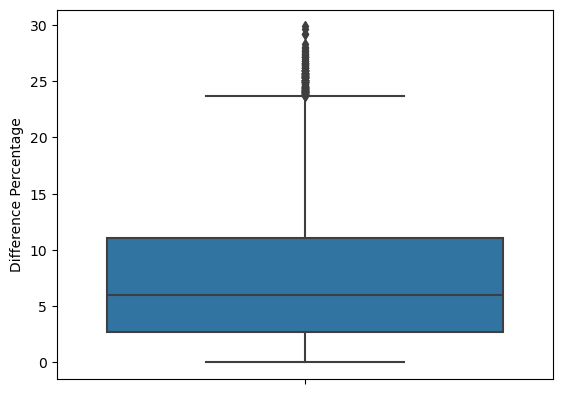

In [20]:
sns.boxplot(y='Difference Percentage', data=pd.DataFrame(results))